# Matching endangered species in A3cat with conservation data from IUCN Red List

![title](https://static.vecteezy.com/system/resources/previews/026/746/427/non_2x/illustration-image-nature-and-sustainability-eco-friendly-living-and-conservation-concept-art-of-earth-and-animal-life-in-different-environments-generative-ai-illustration-free-photo.jpg)

This notebook analyzes species conservation statuses by integrating **IUCN Red List data** with genomic availability information. It generates a **bar plot** to visualize the number of species under different conservation categories.

### **Datasets Used**
- **IUCN Red List Data**: Provides conservation statuses of species.
- **A3CAT**: Arthropoda Assembly Assessment Catalogue, providing which arthropods species have genomes available.

## 1. Import Libraries

In [1]:
import taxonmatch as txm

In [2]:
import logging
# Suppress warnings from the requests library
logging.getLogger("requests").setLevel(logging.ERROR)

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

## 2. Download GBIF and A3cat dataset

In [4]:
gbif_dataset = txm.download_gbif_taxonomy()

GBIF backbone taxonomy data already downloaded.
Processing samples...
Done.


In [5]:
a3cat_dataset = txm.download_ncbi_taxonomy(source = "a3cat")

NCBI taxonomy data already downloaded.
Processing samples...
Done.
a3cat v.2025-01-01 downloaded


## 3. Filtering samples for Arthropoda Phylum

In [6]:
gbif_arthropda, a3cat_arthropoda = txm.select_taxonomic_clade("Arthropoda", gbif_dataset, a3cat_dataset)

## 4. Import xgboost model  

In [7]:
model = txm.load_xgb_model()

## 5. Matching samples

In [8]:
matched_df, unmatched_df, possible_typos_df = txm.match_dataset(gbif_arthropda, a3cat_arthropoda, model, tree_generation = False)

## 6. Add conservation status to the results

In [9]:
df_with_iucn_status = txm.add_iucn_status_column(matched_df)

Progress: 100.00%


In [10]:
last_filtered = df_with_iucn_status[df_with_iucn_status.iucnRedListCategory.isin(['ENDANGERED', 'CRITICALLY_ENDANGERED', 'VULNERABLE'])]

## 4. Filtering and Ordering Conservation Categories

Defining Conservation Status Order
To ensure a meaningful visualization, conservation statuses are sorted from most endangered to least endangered.

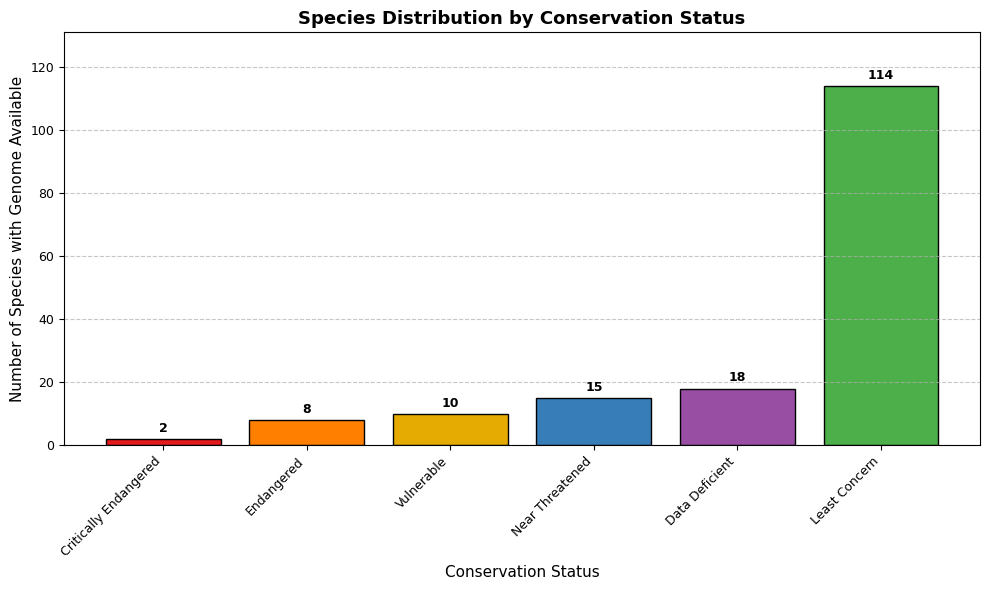

In [12]:
txm.plot_conservation_statuses(df_with_iucn_status)